# 第七章 综合不同模型的组合学习
    1 以多数票机制为基础作出预测
    2 使用套袋通过反复从训练集可重复随即抽取样本组合减少过拟合
    3 利用激励，在从错误中学习的若学习"""

In [3]:
from scipy.special import comb

In [4]:
import math

In [5]:
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs =  [comb(n_classifier, k) *
              error**k *
              (1-error)**(n_classifier - k)
              for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [6]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [7]:
# 0.0から1.0までの範囲内の集成誤り率を計算して、その結果を図表で表す

In [8]:
import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
error_range = np.arange(0.0, 1.01, 0.01)

In [11]:
ens_errors = [ensemble_error(n_classifier=11, error=i) for i in error_range]

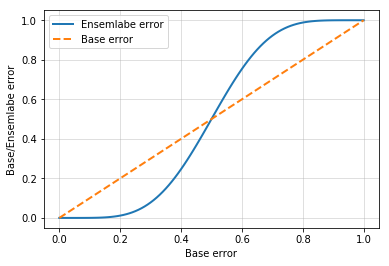

In [12]:
plt.plot(error_range, ens_errors,
         label='Ensemlabe error', linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemlabe error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [13]:
# 上の結果から、ベスエーラが０．５以下であれば、集成分類は性能が基本分類のほうを上回るという結論が得られる。

# ７．２　多数決による集成分類器

# 7.2.1 多数決による簡単分類器の実装

In [14]:
import numpy as np

In [15]:
# 権重による衆数計算
np.argmax(np.bincount([0, 0, 1],
          weights=[0.2, 0.2, 0.6]))

1

In [16]:
# 实现MajorityVoteClassifier

In [17]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [18]:
class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier
    
    
    Parameters
    ----------
    
    classifiers: array-like, shape = [n_classifiers]
        Different classfiiers for the ensemble
    
    vote: str, {'classlabel', 'probability'}
    
    Default: 'classlabel'
        If 'classlabel' the prediction is based on
        the argmax of the class labels. Else if 
        'probability', the argmax of the sum of 
        probabilities is used to predict the class
        label(recommended for calibrated classifiers).
    
    weights: array-like, shape = [n_classifiers]
     optional, default: None
     If a list of 'int' or 'float' values are
     provided, the classifiers are weighted by
     importance; Users uniform weights if 'weights=None'.
     
    """
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for 
                                  key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """ Fit classifiers.
        
        Paramenters
        -----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        -------
        self : object
        
        """
        # Use LabelEncoder to ensure class labels start with 0, which is important for np.argmax 
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, 
                                        self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
            
        
        Returns
        ---------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) 
                                      for clf in 
                                      self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                            lambda x:
                            np.argmax(np.bincount(x, 
                                                  weights=self.weights)),
                            axis=1,
                            arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix},
             shape = [n_samples, n_features]
             Training vectors, where n_samples is the 
             number of samples and n_features is the
             number of features
             
        Returns
        ---------
        avg_proba : array-like,
                    shape = [n_samples, n_classes]
                    Weighted average probability for 
                    each class per sample.
                    
        """
        probas = np.asarray([clf.predict_proba(X) for 
                            clf in self.classifiers_])
        avg_proba = np.average(probas,
                               axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GrtidSearch """
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                    step.get_params(deep=True)):
                    out["%s__%s" % (name, key)] = value
            return out

# 7.2.2 用多数票原则进行预测

In [20]:
from sklearn import datasets

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
iris = datasets.load_iris()

In [25]:
X, y = iris.data[50:, [1, 2]], iris.target[50:]

In [26]:
le = LabelEncoder()

In [27]:
y = le.fit_transform(y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, 
                                                    random_state=1,
                                                    stratify=y)

# 使用三种不同分类器
    # 逻辑回归分类器
    # 决策树分类器
    # k-近隣分类器

# 在构建继承分类其之前，县通过对训练集进行10次交叉验证以评估每个分类其模型的性能

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
from sklearn.pipeline import Pipeline

In [34]:
import numpy as np

In [35]:
clf1 = LogisticRegression(penalty='l2',
                          C=0.01,
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

In [36]:
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

In [37]:
clf_labels = ['LogisticRegression', 'Decision tree', 'KNN']

In [38]:
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=-1,
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.89 (+/- 0.17) [LogisticRegression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


# 在MajorityVoteClassifier类中进行继承独立的分类其进行多数票决策

In [40]:
mv_clf = MajorityVoteClassifier(
                classifiers=[pipe1, clf2, pipe3])

In [41]:
clf_labels += ['Majority voting']

In [42]:
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [43]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=-1,
                             scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
                % (scores.mean(), scores.std(), label))

Accuracy: 0.89 (+/- 0.17) [LogisticRegression]
Accuracy: 0.89 (+/- 0.16) [Decision tree]
Accuracy: 0.88 (+/- 0.15) [KNN]
Accuracy: 0.96 (+/- 0.13) [Majority voting]


# 7.2.3 评估和优化继承分类其

In [45]:
from sklearn.metrics import roc_curve

In [46]:
from sklearn.metrics import auc

In [47]:
colors = ['black', 'orange', 'blue', 'green']

In [48]:
linestyles = [':', '--', '-.', '-']

/home/ishikawa407/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ishikawa407/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


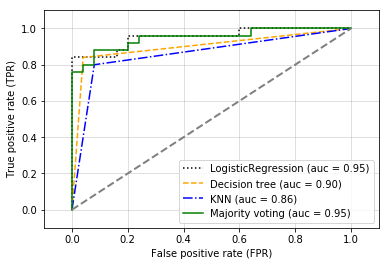

In [49]:
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, 
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

# 7.3 袋装--基于导引样本构建分类器集成
        # 与MajorityVoteClassifier紧密相关
        # 从初始训练集中抽取自举样本（随机可替换样本）也被成为引导聚合
        
"""
"""

7.3.2 应用套装技术对葡萄酒数据集中的样本分类

In [50]:
import pandas as pd

In [59]:
df_wine = pd.read_csv('wine.data', header=None)

In [60]:
df_wine[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [61]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alacinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

In [62]:
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

In [63]:
y = df_wine['Class label'].values

In [66]:
X = df_wine[['Alcohol', 
             'OD280/OD315 of diluted wines']].values

In [69]:
# 用二进制为分类标签编码，按8：2比例把数据集分裂为训练集和测试集

In [70]:
from sklearn.preprocessing import LabelEncoder

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
le = LabelEncoder()

In [74]:
y = le.fit_transform(y)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, stratify=y, random_state=1)

In [76]:
# scikit-learn 实现BaggingClassifier

In [77]:
from sklearn.ensemble import BaggingClassifier

In [78]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=None)

In [79]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [80]:
from sklearn.metrics import accuracy_score

In [83]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [84]:
tree_train = accuracy_score(y_train, y_train_pred)

In [85]:
tree_test = accuracy_score(y_test, y_test_pred)

In [86]:
print('Decision tree train/test accuracies %.3f/%.3f'
         % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [87]:
# 修剪决策树对测试准确率相当低

In [88]:
bag = bag.fit(X_train, y_train)

In [89]:
y_trian_pred = bag.predict(X_train)

In [91]:
y_test_pred = bag.predict(X_test)

In [92]:
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

In [93]:
print('Bagging train/test accuracies %.3f/%.3f'
         % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


In [94]:
# 套袋分类器在测试集上估计的泛化性能略好

In [96]:
# 比较决策树和套袋分类器之间在决策区域的差别
    # 套袋算法可以有效的减少模型方差
    # 对减少模型偏差方面无效
    # 低偏差集成分类器上实现套袋 如修剪决策树

# 7.4 通过自适应增强来利用弱学习者
    Adaboost 自适应增强